# Training neural network force fields (NNFFs) with AMPtorch


Edited by N. Hu

Medford Research Group at Georgia Tech

08/26/2021

This ipython notebook of training NNFFs is based on the BDQM-VIP lecture materials and the sample scripts provided by AMPtorch (`amptorch/example/`) for both conventional Symmetry Functions as finger-printing scheme + Behler-Parrnello atomistic neural network structure (2nd Generation NN), and Gaussian Multi-Pole + SingleNN neural network structure.

This paper introduces the basics and the formulation of Gaussian Multi-pole (GMP) descriptors: 
<https://arxiv.org/abs/2102.02390?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%253A+arxiv%252FQSXk+%2528ExcitingAds%2521+cs+updates+on+arXiv.org%2529>


# Table of contents
1. [Training with Symmetry Function and BPNN](#training_bp)
2. [Training with GMP and SingleNN](#training_gmp)

## Training on CuCO with Symmetry Functions + 2nd Gen NNFF <a name="training_bp"></a>

### Construct the training dataset

As an example, we calculate the potential energy and forces for CuCO chemical system with the EMT calculator implemented in ase. 

This step should be replaced with training datasets that have information on:
1. cell size
2. periodic boundary conditions
3. atomic positions
4. potential energy
5. forces, if doing force training

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from ase import Atoms
import ase.io
from ase.calculators.emt import EMT
from ase.build import molecule


from amptorch.ase_utils import AMPtorch
from amptorch.trainer import AtomsTrainer

In [2]:
# get training images

distances = np.linspace(2, 5, 100)
images = []
for dist in distances:
    image = Atoms(
        "CuCO",
        [
            (-dist * np.sin(0.65), dist * np.cos(0.65), 0),
            (0, 0, 0),
            (dist * np.sin(0.65), dist * np.cos(0.65), 0),
        ],
    )
    image.set_cell([10, 10, 10])
    image.wrap(pbc=True)
    image.set_calculator(EMT())
    images.append(image)

### Define fingerprinting scheme

Here we demonstrate with the conventional Symmetry functions, $G^2$ and $G^4$. 

In [3]:
# define parameters for finger-printing scheme, Symmetry Function

Gs = {
    "default": {
        "G2": {
            "etas": np.logspace(np.log10(0.05), np.log10(5.0), num=4),
            "rs_s": [0],
        },
        "G4": {"etas": [0.005], "zetas": [1.0, 4.0], "gammas": [1.0, -1.0]},
        "cutoff": 6,
    },
}

### Define the configuration for trainer object

Detailed introductions and other specifications supported in trainer object can be found here under Section Usage/Configs: 
<https://github.com/ulissigroup/amptorch/tree/MCSH_paper1_lmdb>

In [4]:
config = {
    "model": {
        "get_forces": True,
        "num_layers": 3,
        "num_nodes": 5,
        "batchnorm": True,
    },
    "optim": {
        "force_coefficient": 0.04,
        "lr": 1e-3,
        "batch_size": 32,
        "epochs": 10,
        "loss": "mse",
        "metric": "mae",
        "gpus": 0,
    },
    "dataset": {
        "raw_data": images,
        "fp_params": Gs,
        "save_fps": True,
        "scaling": {"type": "normalize", "range": (0, 1)},
        "val_split": 0,
    },
    "cmd": {
        "debug": False,
        "run_dir": "./",
        "seed": 1,
        "identifier": "test",
        "verbose": True,
        # Weights and Biases used for logging - an account(free) is required
        "logger": False,
    },
}

### Hit go and train

In [5]:
torch.set_num_threads(1)
trainer = AtomsTrainer(config)
trainer.train()

Results saved to ./checkpoints/2021-08-26-16-52-57-test



Loading dataset: 100 images
Loading model: 1023 parameters
Loading skorch trainer
  epoch    train_energy_mae    train_forces_mae    train_loss    cp     dur
-------  ------------------  ------------------  ------------  ----  ------
      1              0.6699              0.3765        0.4504     +  0.0366
      2              0.5186              0.3440        0.4043     +  0.0354
      3              0.4314              0.3344        0.3154     +  0.0354
      4              0.4169              0.3338        0.3565     +  0.0352
      5              0.3966              0.3392        0.2084     +  0.0349


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


      6              0.3887              0.3378        0.4124     +  0.0348
      7              0.3740              0.3360        0.1773     +  0.0341
      8              0.3564              0.3336        0.2445     +  0.0335
      9              0.3358              0.3375        0.1515     +  0.0336
     10              0.2942              0.3359        0.2218     +  0.0336
Training completed in 0.4174649715423584s


0.4174649715423584

### Use the neural network as an ase calculator to make predictions

In [6]:
predictions = trainer.predict(images)

# assess errors

true_energies = np.array([image.get_potential_energy() for image in images])
pred_energies = np.array(predictions["energy"])

print("Energy MSE:", np.mean((true_energies - pred_energies) ** 2))
print("Energy MAE:", np.mean(np.abs(true_energies - pred_energies)))

images[0].set_calculator(AMPtorch(trainer))
images[0].get_potential_energy()

Energy MSE: 0.41248591114113947
Energy MAE: 0.3939685106821985


10.50893783569336

## Training on 2D water dataset with GMP + SingleNN <a name="training_gmp"></a>

### Construct the training dataset

As an example of the training dataset, we calculate the potential energy and forces for 2-D single water potential energy surface. This dataset is calculated by Quantem Espresso (xc, PBE. kpts, (1,1,1). Planewave, 500.) One O-H bond length is fixed, and the other O-H length and the H-O-H bond angle are allowed to vary. 

Required information in the training datasets contains:
1. cell size
2. periodic boundary conditions
3. atomic positions
4. potential energy
5. forces, if doing force training

In [7]:
# get training images by reading trajectory files

# read all images from the trajectory
training = ase.io.read("./data/water_2d.traj", index=":")

# read every 10th image from the trajectory
# training = ase.io.read("./data/water_2d.traj", index="::10")

# print the length of the image
len(training)

400

In [8]:
# check the information

# cell size
print(training[0].get_cell())

# periodic boundary condition
print(training[0].get_pbc())

# atomic positions
print(training[0].get_positions())

# system potential energy
print(training[0].get_potential_energy())

# forces
print(training[0].get_forces())

# ase.Atoms object
print(training[0])

Cell([10.0, 10.0, 10.0])
[ True  True  True]
[[5.         4.82418565 5.2981545 ]
 [5.         5.58742465 4.7018455 ]
 [5.         4.41257535 4.77131852]]
-593.6701598080588
[[  0.          31.22263082  36.76981108]
 [  0.           1.73799984   1.01589577]
 [  0.         -32.96063066 -37.78570684]]
Atoms(symbols='OH2', pbc=True, cell=[10.0, 10.0, 10.0], calculator=SinglePointCalculator(...))


### Define fingerprinting scheme

Here we demonstrate with the GMP fingerprinting scheme. It requires the fitted pseduo-potentials of every elements. Access to the fitted pseduo-potentials:
<https://github.com/ulissigroup/amptorch/tree/MCSH_paper1_lmdb/examples/GMP/valence_gaussians>

Like G2 and G4 symmetry functions, GMP uses $\sigma$'s in the radial coordinates and MCSH groups and orders in the angular coordinates.

In [9]:
sigmas = [0.2, 0.69, 1.1, 1.66, 2.66]

MCSHs = {
    "MCSHs": {
        "0": {"groups": [1], "sigmas": sigmas},
        "1": {"groups": [1], "sigmas": sigmas},
        "2": {"groups": [1, 2], "sigmas": sigmas},
#         "3": {"groups": [1, 2, 3], "sigmas": sigmas},
#         "4": {"groups": [1, 2, 3, 4], "sigmas": sigmas},
        # "5": {"groups": [1, 2, 3, 4, 5], "sigmas": sigmas},
        # "6": {"groups": [1, 2, 3, 4, 5, 6, 7], "sigmas": sigmas},
    },
    "atom_gaussians": {
        "H": "./valence_gaussians/H_pseudodensity_2.g",
        "O": "./valence_gaussians/O_pseudodensity_4.g",
    },
    "cutoff": 8,
}

elements = ["H", "O"]

### Define the configuration for trainer object

Detailed introductions and other specifications supported in trainer object can be found here under Section Usage/Configs: 
<https://github.com/ulissigroup/amptorch/tree/MCSH_paper1_lmdb>

In [10]:
config = {
    "model": {
        "name":"singlenn",
        "get_forces": True,
        "num_layers": 3,
        "num_nodes": 10,
        "batchnorm": True,
    },
    "optim": {
        "force_coefficient": 0.01,
        "lr": 1e-3,
        "batch_size": 16,
        "epochs": 500,
        "loss": "mse",
        "metric": "mae",
    },
    "dataset": {
        "raw_data": training,
        "fp_scheme": "gmp",
        "fp_params": MCSHs,
        "elements": elements,
        "save_fps": True,
        "scaling": {"type": "normalize", "range": (0, 1)},
        "val_split": 0.1,
    },
    "cmd": {
        "debug": False,
        "run_dir": "./",
        "seed": 1,
        "identifier": "test",
        "verbose": True,
        # Weights and Biases used for logging - an account(free) is required
        "logger": False,
    },
}

### Hit go and train

In [11]:
torch.set_num_threads(1)
trainer = AtomsTrainer(config)
trainer.train()

Results saved to ./checkpoints/2021-08-26-16-53-02-test



Loading dataset: 400 images
Loading model: 371 parameters
Loading skorch trainer
  epoch    train_energy_mae    train_forces_mae    train_loss    val_energy_mae    val_forces_mae    valid_loss    cp     dur
-------  ------------------  ------------------  ------------  ----------------  ----------------  ------------  ----  ------
      1              1.4376              2.5889        0.5513            1.4880            3.1067        0.6659     +  0.1111
      2              0.9171              2.5969        0.2900            0.9112            2.3525        0.3266     +  0.1087
      3              0.6900              2.6226        0.2045            0.5069            2.4538        0.2256     +  0.1080
      4              0.5156              2.5666        0.1560            0.4262            2.3863        0.1876     +  0.1083
      5              0.4824              2.5806        0.1489            0.4354            2.1777        0.1554        0.1091
      6              0.4413         

     54              0.1974              1.2507        0.0190            0.1543            0.9788        0.0122        0.1105
     55              0.2010              1.2763        0.0195            0.1882            1.0059        0.0148        0.1154
     56              0.1619              1.2420        0.0152            0.1670            1.1744        0.0142        0.1193
     57              0.1899              1.1925        0.0174            0.1720            1.0814        0.0162        0.1137
     58              0.1911              1.2021        0.0197            0.1386            1.0176        0.0111        0.1092
     59              0.1879              1.1874        0.0166            0.1358            1.0939        0.0118        0.1102
     60              0.1664              1.1516        0.0134            0.1503            0.9794        0.0115        0.1137
     61              0.1792              1.1591        0.0152            0.1429            1.0152        0.0130       

    114              0.1238              0.8692        0.0079            0.0881            0.7517        0.0043        0.1147
    115              0.1306              0.8777        0.0094            0.0745            0.7836        0.0042        0.1161
    116              0.1079              0.8383        0.0064            0.0659            0.8047        0.0040        0.1128
    117              0.1452              0.8595        0.0153            0.0977            0.8160        0.0056        0.1125
    118              0.1642              0.8912        0.0138            0.1387            0.7944        0.0093        0.1134
    119              0.1513              0.8647        0.0105            0.0951            0.8193        0.0054        0.1136
    120              0.1295              0.8624        0.0092            0.0799            0.8154        0.0051        0.1139
    121              0.1086              0.8308        0.0069            0.0737            0.7839        0.0039       

    177              0.0969              0.7513        0.0061            0.0582            0.6916        0.0031        0.1110
    178              0.1039              0.7508        0.0065            0.0884            0.6670        0.0040        0.1098
    179              0.0996              0.7227        0.0052            0.0813            0.7257        0.0039        0.1128
    180              0.1046              0.6849        0.0052            0.0659            0.6677        0.0034        0.1200
    181              0.1165              0.7497        0.0066            0.0579            0.6819        0.0029        0.1178
    182              0.0964              0.7563        0.0055            0.0714            0.6808        0.0038        0.1098
    183              0.1085              0.7056        0.0060            0.1278            0.7350        0.0118        0.1101
    184              0.1265              0.7523        0.0078            0.1064            0.6540        0.0052       

    240              0.1094              0.6758        0.0061            0.0772            0.5720        0.0029        0.1139
    241              0.0979              0.6766        0.0059            0.0673            0.7049        0.0039        0.1146
    242              0.1020              0.6322        0.0049            0.0691            0.6103        0.0031        0.1141
    243              0.0934              0.6645        0.0053            0.0567            0.6065        0.0024        0.1134
    244              0.0902              0.7035        0.0048            0.0584            0.5881        0.0026        0.1136
    245              0.1014              0.6292        0.0046            0.0595            0.5771        0.0023        0.1123
    246              0.1099              0.6907        0.0061            0.0776            0.5911        0.0040        0.1141
    247              0.0897              0.6421        0.0043            0.0761            0.5590        0.0028       

    304              0.1089              0.6177        0.0055            0.1028            0.6216        0.0057        0.1134
    305              0.1017              0.6301        0.0049            0.0829            0.6504        0.0036        0.1113
    306              0.0930              0.5862        0.0047            0.0551            0.6286        0.0026        0.1120
    307              0.0907              0.5736        0.0040            0.0502            0.5517        0.0019        0.1104
    308              0.0894              0.5892        0.0038            0.0721            0.6008        0.0032        0.1124
    309              0.1038              0.6097        0.0049            0.0471            0.5815        0.0019     +  0.1129
    310              0.0761              0.5628        0.0031            0.0753            0.6158        0.0033        0.1116
    311              0.1077              0.6471        0.0058            0.0816            0.6479        0.0041       

    369              0.0895              0.5710        0.0038            0.0538            0.4939        0.0018        0.1119
    370              0.0887              0.5595        0.0039            0.0615            0.5578        0.0029        0.1101
    371              0.0856              0.5488        0.0048            0.0499            0.5623        0.0020        0.1097
    372              0.1100              0.6183        0.0058            0.0702            0.4867        0.0024        0.1110
    373              0.1012              0.6159        0.0055            0.0788            0.5878        0.0038        0.1118
    374              0.0835              0.5272        0.0034            0.0698            0.5883        0.0031        0.1091
    375              0.0812              0.5456        0.0036            0.1042            0.5025        0.0049        0.1102
    376              0.0904              0.6002        0.0042            0.0611            0.5231        0.0022       

    434              0.0836              0.5361        0.0034            0.0761            0.5969        0.0046        0.1181
    435              0.0837              0.5243        0.0035            0.0655            0.5752        0.0028        0.1153
    436              0.0852              0.5262        0.0038            0.0507            0.5224        0.0020        0.1123
    437              0.0935              0.5422        0.0043            0.0642            0.5531        0.0028        0.1141
    438              0.0920              0.5488        0.0043            0.0600            0.5028        0.0021        0.1146
    439              0.0905              0.5192        0.0038            0.0998            0.5935        0.0061        0.1158
    440              0.0799              0.4857        0.0028            0.0413            0.5292        0.0017     +  0.1143
    441              0.0729              0.5237        0.0029            0.0468            0.5141        0.0018       

    499              0.0726              0.4981        0.0029            0.0511            0.5232        0.0019        0.1117
    500              0.0742              0.5025        0.0027            0.0676            0.5580        0.0032        0.1135
Training completed in 81.75729441642761s


81.75729441642761

### Use the neural network as an ase calculator to make predictions

In [12]:
predictions = trainer.predict(training)

# assess errors

true_energies = np.array([image.get_potential_energy() for image in training])
pred_energies = np.array(predictions["energy"])

print("Energy MSE:", np.mean((true_energies - pred_energies) ** 2))
print("Energy MAE:", np.mean(np.abs(true_energies - pred_energies)))

training[0].set_calculator(AMPtorch(trainer))
training[0].get_potential_energy()

Energy MSE: 0.002619624668211535
Energy MAE: 0.03989354546070956


-593.8114013671875

### Use the fitted model to predict the 1D PES for change in O-H bond length

In [13]:
# set up images with one changing bond length
distances = np.linspace(0.4, 2.0, 100)
images = []
for dist in distances:
    image = molecule("H2O", vacuum=10.0)
    image.set_cell([10, 10, 10])
    image.set_pbc([1, 1, 1])

    # change bond length
    image.set_distance(0, 2, dist)
    image.set_angle(1, 0, 2, 104.210)
    images.append(image)

predictions = trainer.predict(images)

In [14]:
# get training point

training_angle100 = [_ for _ in training if np.isclose(_.get_angle(1, 0, 2), 104.210, atol=1e-3)]

distances_training = [_.get_distance(0, 2) for _ in training_angle100]
energies_training = [_.get_potential_energy() for _ in training_angle100]


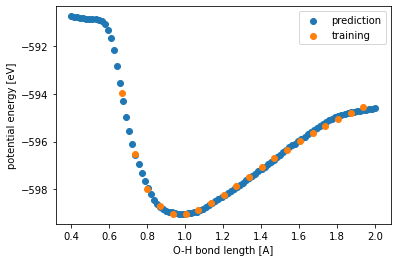

In [15]:
plt.scatter(distances, predictions["energy"], label="prediction")
plt.scatter(distances_training, energies_training, label="training")
plt.xlabel("O-H bond length [A]")
plt.ylabel("potential energy [eV]")
plt.legend()